# HW8_Assign1_xj655
### I'm trying plot the subway station entrance  and housing rent on NYC map by PUMA.  Hope to figure out whether the denser subway stations are in one place, the higher the housing rent cost is.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from matplotlib import pyplot as plt
from fiona.crs import from_epsg
import shapely
import os
import io
import glob
import requests
import json
import pysal
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /Users/xiaojing/PUIdata


## 1.Get the PUMA for NYC

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x117b008d0>)

In [4]:
!unzip file.gz

Archive:  file.gz
  inflating: geo_export_24c0a339-2ef7-4e17-b15c-98fa7eba907f.dbf  
  inflating: geo_export_24c0a339-2ef7-4e17-b15c-98fa7eba907f.shp  
  inflating: geo_export_24c0a339-2ef7-4e17-b15c-98fa7eba907f.shx  
  inflating: geo_export_24c0a339-2ef7-4e17-b15c-98fa7eba907f.prj  


In [5]:
for file in os.listdir():
    if file.endswith(".shp"):
        os.rename(file, 'puma.shp')
    elif file.endswith(".shx"):
        os.rename(file, 'puma.shx')
    elif file.endswith(".dbf"):
        os.rename(file, 'puma.dbf')
    elif file.endswith(".prj"):
        os.rename(file, 'puma.prj')

In [6]:
pumashp = gpd.GeoDataFrame.from_file('puma.shp')

In [7]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


### 2. Get data for NYC subway station info

In [8]:
url2 = 'https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=Shapefile'
urllib.urlretrieve(url2, "station.gz")

('station.gz', <http.client.HTTPMessage at 0x117eaf278>)

In [9]:
!unzip station.gz

Archive:  station.gz
  inflating: geo_export_920c48dc-e0b7-41ed-8fb5-ddf4248f6774.dbf  
  inflating: geo_export_920c48dc-e0b7-41ed-8fb5-ddf4248f6774.shp  
  inflating: geo_export_920c48dc-e0b7-41ed-8fb5-ddf4248f6774.shx  
  inflating: geo_export_920c48dc-e0b7-41ed-8fb5-ddf4248f6774.prj  


In [11]:
stationshp = gpd.GeoDataFrame.from_file('geo_export_920c48dc-e0b7-41ed-8fb5-ddf4248f6774.shp')

In [12]:
stationshp.head()

,line,name,objectid,url,geometry
0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (-73.86835600032798 40.84916900104506)
1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (-73.86821300022677 40.84912800131844)
2,2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/,POINT (-73.87349900050798 40.84122300105249)
3,2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/,POINT (-73.87289199978331 40.84145300067447)
4,2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/,POINT (-73.87962300013866 40.84081500075867)


In [13]:
stationshp.shape

(1928, 5)

## 3. Download the csv data for housing rent cost by PUMA.

In [17]:
#Dataset for housing rent cost. HD01_VD01 means total housing units. HD02_VD01 means std for the previous column(which will be drop later. 
#HD01_VD02 means the number of unit of which rent is from 0-$100, each bin's range is $100. For example, n*100 to n*100+$100 is the interval for Column HD01_VD(n+2). 
acs = pd.read_csv("ACS_16_1YR_B25104_with_ann.csv").drop(index=0).reset_index(drop=True)
acs['GEO.id2'] = acs['GEO.id2'].astype(int) - 3600000
acs.head(50)

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,...,HD01_VD13,HD02_VD13,HD01_VD14,HD02_VD14,HD01_VD15,HD02_VD15,HD01_VD16,HD02_VD16,HD01_VD17,HD02_VD17
0,7950000US3600100,100,"St. Lawrence County PUMA, New York",40479,1519,85,90,1004,422,4013,...,1710,448,787,307,332,206,461,296,906,328
1,7950000US3600200,200,"Clinton, Franklin, Essex & Hamilton Counties P...",67092,2054,404,230,1500,514,4963,...,4312,961,1614,449,527,299,447,235,1593,557
2,7950000US3600300,300,"Warren & Washington Counties PUMA, New York",51614,1736,172,162,668,316,1939,...,5399,931,2226,654,787,378,785,324,703,384
3,7950000US3600401,401,Herkimer (North & Central) & Oneida (Outer) Co...,44300,1723,27,34,1574,507,2595,...,3163,684,984,406,163,91,294,198,1130,485
4,7950000US3600402,402,Oneida County (Central)--Greater Utica & Rome ...,61146,1901,166,134,636,289,2871,...,3461,812,2181,783,546,308,1020,457,1018,463
5,7950000US3600403,403,"Otsego, Schoharie, Oneida (South) & Herkimer (...",42081,1597,163,144,1196,389,2554,...,3362,599,1338,411,655,295,532,230,886,359
6,7950000US3600500,500,"Jefferson & Lewis Counties PUMA, New York",50860,1725,106,92,1222,516,2871,...,5137,1007,1464,430,570,289,399,231,982,393
7,7950000US3600600,600,"Oswego County PUMA, New York",44633,1313,0,192,533,272,2264,...,3232,799,1367,578,187,149,402,298,1117,441
8,7950000US3600701,701,"Onondaga County (Central)--Syracuse City PUMA,...",56295,2177,368,219,940,394,2912,...,2293,658,597,307,151,185,221,230,556,312
9,7950000US3600702,702,"Onondaga County (North) PUMA, New York",47988,1841,40,64,397,257,1118,...,6338,1073,2136,605,1109,437,1209,570,693,428


In [18]:
#the number for column 100~200 means (the unit in the interval)/ (total unit)
acs_new = acs.rename(columns={'GEO.id2' :'puma','HD01_VD01':'total units'}).iloc[:,1::2]
acs_new['total units'] = acs_new['total units'].astype(int)
for i in range(2,18):
    acs_new.rename(columns={acs_new.columns[i] :'$%d~%d'%((int(i-2)*100),int((i-1)*100))}, inplace=True)
    acs_new[acs_new.columns[i]] = acs_new[acs_new.columns[i]].astype(int)
    acs_new[acs_new.columns[i]] = acs_new[acs_new.columns[i]]/acs_new['total units']
acs_new.head()

,puma,total units,$0~100,$100~200,$200~300,$300~400,$400~500,$500~600,$600~700,$700~800,$800~900,$900~1000,$1000~1100,$1100~1200,$1200~1300,$1300~1400,$1400~1500,$1500~1600
0,100,40479,0.002100,0.024803,0.099138,0.087082,0.111539,0.082240,0.095037,0.101509,0.061044,0.056326,0.175523,0.042244,0.019442,0.008202,0.011389,0.022382
1,200,67092,0.006022,0.022357,0.073973,0.074420,0.090786,0.100802,0.107867,0.083244,0.075449,0.066521,0.171973,0.064270,0.024057,0.007855,0.006662,0.023744
2,300,51614,0.003332,0.012942,0.037567,0.081335,0.061166,0.070698,0.078273,0.063975,0.083582,0.064944,0.250378,0.104603,0.043128,0.015248,0.015209,0.013620
3,401,44300,0.000609,0.035530,0.058578,0.084673,0.096366,0.094898,0.105801,0.083070,0.073115,0.050113,0.187810,0.071400,0.022212,0.003679,0.006637,0.025508
4,402,61146,0.002715,0.010401,0.046953,0.060593,0.094348,0.094577,0.104013,0.110539,0.075442,0.066971,0.198917,0.056602,0.035669,0.008929,0.016681,0.016649


In [19]:
acs_new.shape

(145, 18)

In [20]:
# I'm going to look for the median rent price located in which interval.
#When find the interval, I use the middle number of the interval as the median rent for that area.
acumu = 0
acs_new['median rent'] = 0
for i in range(144):
    for j in range(2,18):
        if acumu < 0.5:
            acumu+=acs_new.iloc[i,j]
        else:
            acumu = 0
            col = j
            break
    acs_new['median rent'][i] = (col-2)*100+50
acs_new.head()
            

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,puma,total units,$0~100,$100~200,$200~300,$300~400,$400~500,$500~600,$600~700,$700~800,$800~900,$900~1000,$1000~1100,$1100~1200,$1200~1300,$1300~1400,$1400~1500,$1500~1600,median rent
0,100,40479,0.002100,0.024803,0.099138,0.087082,0.111539,0.082240,0.095037,0.101509,0.061044,0.056326,0.175523,0.042244,0.019442,0.008202,0.011389,0.022382,750
1,200,67092,0.006022,0.022357,0.073973,0.074420,0.090786,0.100802,0.107867,0.083244,0.075449,0.066521,0.171973,0.064270,0.024057,0.007855,0.006662,0.023744,850
2,300,51614,0.003332,0.012942,0.037567,0.081335,0.061166,0.070698,0.078273,0.063975,0.083582,0.064944,0.250378,0.104603,0.043128,0.015248,0.015209,0.013620,1050
3,401,44300,0.000609,0.035530,0.058578,0.084673,0.096366,0.094898,0.105801,0.083070,0.073115,0.050113,0.187810,0.071400,0.022212,0.003679,0.006637,0.025508,850
4,402,61146,0.002715,0.010401,0.046953,0.060593,0.094348,0.094577,0.104013,0.110539,0.075442,0.066971,0.198917,0.056602,0.035669,0.008929,0.016681,0.016649,850


In [21]:
medrent_puma = acs_new[['puma','median rent']]
medrent_puma.head()

,puma,median rent
0,100,750
1,200,850
2,300,1050
3,401,850
4,402,850


In [22]:
pumashp.puma = pumashp.puma.astype(int)
rent_puma = gpd.GeoDataFrame(pumashp.merge(medrent_puma,left_on='puma',right_on='puma'))
rent_puma.crs = from_epsg(4436)

rent_puma.head()

,puma,shape_area,shape_leng,geometry,median rent
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1150
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",1150
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,1150
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",1150
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,1150


In [23]:
stationshp.crs=from_epsg(4436)

/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
No handles with labels found to put in legend.


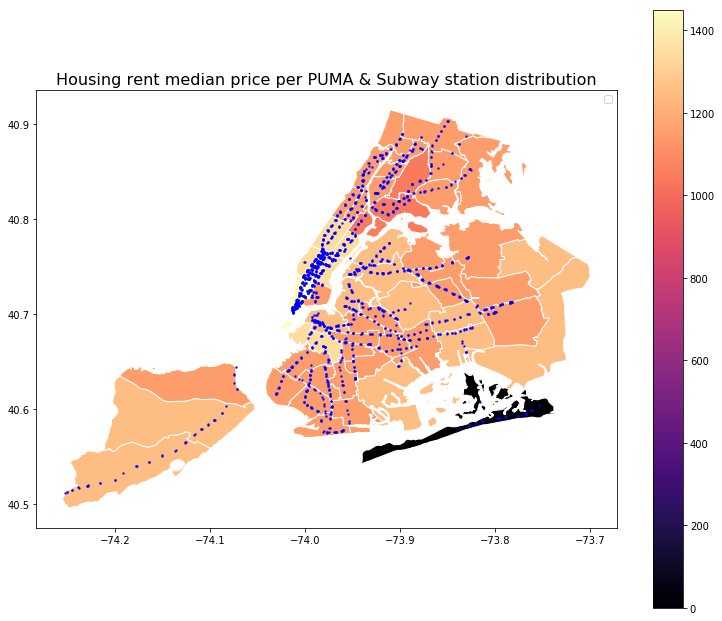

In [29]:
fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(111)
g_plot = rent_puma.plot(column = 'median rent',cmap = 'magma', edgecolor='w', ax=ax,lw=1,k=10,alpha=1.0,legend='median rent price')
stationshp.plot(column='objectid',color='blue',legend='subway entry' ,ax = ax,markersize =2,alpha=0.8)
plt.title('Housing rent median price per PUMA & Subway station distribution',fontsize=16)
plt.legend()

The graph demonstrates the housing median rent cost by PUMA in NYC. THe darker means lower rent per unit and the ligher yellow means higher rent per unit. It shows that in downtown the denser the stations are ,the higher the cost is. However, when the area is far away from downtown, the price have less correlation with station density.

## Plot-Revised
I removed the data of median rent less than 100 which is an outlier for the plot, improving the deliverable of the plot message.
Make the color change by PUMA more diverse.

In [27]:
#revised
rent_puma_1 = rent_puma[rent_puma['median rent']>100]

/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
No handles with labels found to put in legend.


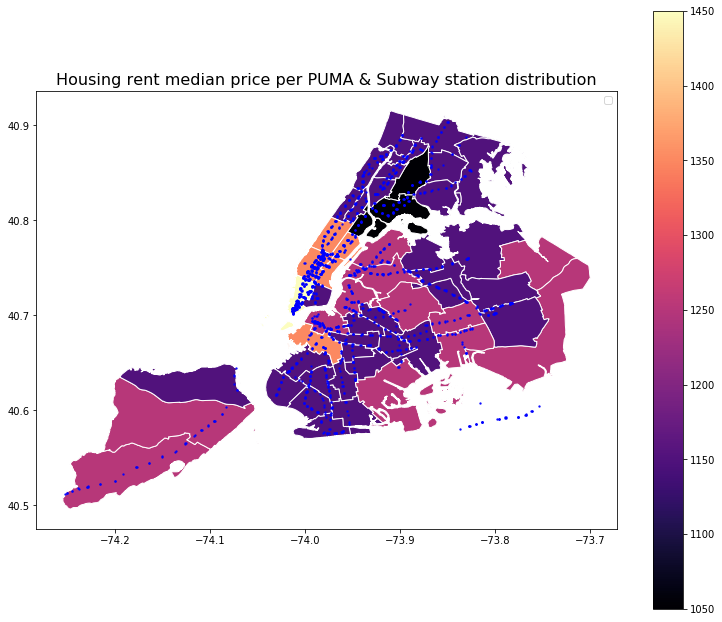

In [28]:
fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(111)
g_plot = rent_puma_1.plot(column = 'median rent',cmap = 'magma', edgecolor='w', ax=ax,lw=1,k=10,alpha=1.0,legend='median rent price')
stationshp.plot(column='objectid',color='blue',legend='subway entry' ,ax = ax,markersize =2,alpha=0.8)
plt.title('Housing rent median price per PUMA & Subway station distribution',fontsize=16)
plt.legend()
#ccent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
#CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, 
#Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, 
#Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, 
#PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, 
#RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, 
#Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, 
#YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, 
#autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, 
#cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, 
#flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, 
#tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_

The graph demonstrates the housing median rent cost by PUMA in NYC. THe darker means lower rent per unit and the ligher yellow means higher rent per unit. It shows that in downtown the denser the stations are ,the higher the cost is. However, when the area is far away from downtown, the price have less correlation with station density.